# Download and Install CLIP Dependencies

In [ ]:
# installing some dependencies, CLIP was released in PyTorch
import subprocess

CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
print("CUDA version:", CUDA_version)

if CUDA_version == "10.0":
    torch_version_suffix = "+cu100"
elif CUDA_version == "10.1":
    torch_version_suffix = "+cu101"
elif CUDA_version == "10.2":
    torch_version_suffix = ""
else:
    torch_version_suffix = "+cu110"

!pip install torch==1.7.1{torch_version_suffix} torchvision==0.8.2{torch_version_suffix} -f https://download.pytorch.org/whl/torch_stable.html ftfy regex

import numpy as np
import torch
import os

print("Torch version:", torch.__version__)
os.kill(os.getpid(), 9)

CUDA version: 11.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |███████████████████████         | 834.1 MB 1.2 MB/s eta 0:04:21tcmalloc: large alloc 1147494400 bytes == 0x3aa04000 @  0x7f816304d615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |█████████████████████████████▏  | 1055.7 MB 1.3 MB/s eta 0:01:21tcmalloc: large alloc 1434370048 bytes == 0x7f05a000 @  0x7f816304d615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0

In [1]:
#clone the CLIP repository
!git clone https://github.com/openai/CLIP.git
%cd CLIP

Cloning into 'CLIP'...
remote: Enumerating objects: 222, done.
remote: Total 222 (delta 0), reused 0 (delta 0), pack-reused 222
Receiving objects: 100% (222/222), 8.91 MiB | 2.98 MiB/s, done.
Resolving deltas: 100% (113/113), done.
/content/CLIP


# Downloading the clip model and our Data
Here we will be downloading the clip model that we will use on the dataset we created on Roboflow.

In [91]:
# download clip model
!pip install -q roboflow
from roboflow import Roboflow
rf = Roboflow(model_format="clip", notebook="roboflow-clip")

upload and label your dataset, and get an API KEY here: https://app.roboflow.com/?model=clip&ref=roboflow-clip


In [4]:
# download classification data
rf = Roboflow(api_key="jyWhsscgsT3D1GKlldiT")
project = rf.workspace("project-vkjtv").project("pictures-classification")
dataset = project.version(2).download("clip")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Pictures-classification-2 in clip:: 100%|██████████| 1119/1119 [00:01<00:00, 800.84it/s]


In [5]:
dataset.location

'/content/CLIP/Pictures-classification-2'

'None Professional picture'/  'Professional picture'/   _tokenization.txt


In [6]:
import os
# our the classes and images we want to test are stored in folders in the test set
class_names = os.listdir(dataset.location + '/test/')
class_names.remove('_tokenization.txt')
class_names
# Here we have two classes

['Professional picture', 'None Professional picture']

In [8]:
# editing our prompts to try to get the best acuuracy, be sure the classes are in the same order as above
%%writefile {dataset.location}/test/_tokenization.txt
A smiling face indoor professional picture
Not a smiling face outdoor none professional picture and not a person picture

Overwriting /content/CLIP/Pictures-classification-2/test/_tokenization.txt


In [9]:
candidate_captions = []
with open(dataset.location + '/test/_tokenization.txt') as f:
    candidate_captions = f.read().splitlines()

In [10]:
candidate_captions

['A smiling face indoor professional picture',
 'Not a smiling face outdoor none professional picture and not a person picture']

## Runing CLIP inference on our classification dataset

In [ ]:
import torch
import clip
import glob
from matplotlib import pyplot as plt
from PIL import Image
import cv2

DATADIR = "/content/CLIP/Pictures-classification-2/test/"
CATEGORIES = ["None Professional picture", "Professional picture"]

def argmax(iterable):
    return max(enumerate(iterable), key=lambda x: x[1])[0]

device = "cuda" if torch.cuda.is_available() else "cpu"
model, transform = clip.load("ViT-B/32", device=device)

correct = []
prediction = []
reality = []

TP = []
TN = []
FP = []
FN = []
Total =[]

#define our target classificaitons, you can should experiment with these strings of text as you see fit, though, make sure they are in the same order as your class names above
text = clip.tokenize(candidate_captions).to(device)

for category in CATEGORIES:
  path = os.path.join(DATADIR, category)

for cls in class_names:
    class_correct = []
    test_imgs = glob.glob(dataset.location + '/test/' + cls + '/*.jpg')
    text_features = model.encode_text(text)
    for img in test_imgs:
        # print(img)
        img_array = cv2.imread(os.path.join(path, img))
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        plt.imshow(img_array)
        plt.show()

        image = transform(Image.open(img)).unsqueeze(0).to(device)
        with torch.no_grad():
            image_features = model.encode_image(image)
            
            logits_per_image, logits_per_text = model(image, text)
            probs = logits_per_image.softmax(dim=-1).cpu().numpy()
            print(probs)

            pred = class_names[argmax(list(probs)[0])]
            prediction.append(pred)
            print('prediction is :' + pred)
            reality.append(cls)
            print('reality is :' + cls)

            if pred == cls:
                correct.append(1)
                class_correct.append(1)
            else:
                correct.append(0)
                class_correct.append(0)

            if cls == "Professional picture" and pred == cls :
              TP.append(1)
              Total.append(1)
            elif cls == "None Professional picture" and pred == cls :
              TN.append(1)
              Total.append(1)
            elif cls == "Professional picture" and pred != cls :
              FP.append(1)
              Total.append(1)
            elif cls == "None Professional picture" and pred != cls :
              FN.append(1)
              Total.append(1)
    
    print('accuracy on class ' + cls + ' is :' + str(sum(class_correct)/len(class_correct)))
    if cls == "Professional picture":
      Professional_accuracy = str(sum(class_correct)/len(class_correct))
print('accuracy on class Professional picture is :' + Professional_accuracy)

print("#####" * 50)
print("Accuracy on all is : " + str((sum(TP) + sum(TN))/sum(Total)))
print("Recall on all is : " + str(sum(TP)/(sum(TP) + sum(FN))))
print("Precision on all is : " + str(sum(TP)/(sum(TP) + sum(FP))))
print("F1 Score is : " + str((2 * sum(TP))/(2 * sum(TP) + sum(FP) + sum(FN))))
print("Specificity on all is : " + str(sum(TN)/(sum(TN) + sum(FP))))
print("FPR on all is : " + str(sum(FP)/(sum(FP) + sum(TN))))
print("FNR on all is : " + str(sum(FN)/(sum(FN) + sum(TP))))

In [197]:
file_name_1 = glob.glob(dataset.location + '/test/' + 'None Professional picture' + '/*.jpg')
file_name_2 = glob.glob(dataset.location + '/test/' + 'Professional picture' + '/*.jpg')
file_name = file_name_1 + file_name_2

In [ ]:
file_name_1

In [199]:
df = pd.DataFrame(data=file_name)
df.columns=["file_name"]

In [201]:
df["None Professional"]=df["file_name"].apply(lambda x: 1 if x in file_name_1 else 0)
df["Professional"]=df["file_name"].apply(lambda x: 1 if x in file_name_2 else 0)

In [ ]:
df

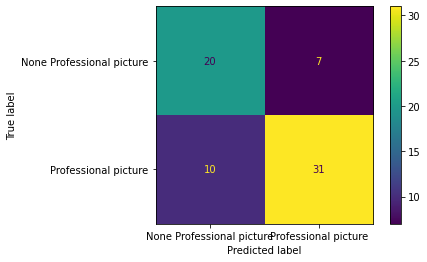

In [153]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(reality, prediction)

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image as img
import cv2
import glob

In [13]:
DATADIR = "/content/drive/MyDrive/Images"


texte = clip.tokenize(candidate_captions).to(device)
predictions = []


imgs = glob.glob(DATADIR + '/*.png')
texte_features = model.encode_text(texte)
for img in imgs:
    image_array = cv2.imread(os.path.join(DATADIR, img))
    # image_array = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)
    # plt.imshow(image_array)
    # plt.show()

    image = transform(Image.open(img)).unsqueeze(0).to(device)
    with torch.no_grad():
          image_features = model.encode_image(image)

              
          logits_per_image, logits_per_texte = model(image, texte)
          probs = logits_per_image.softmax(dim=-1).cpu().numpy()
          # print(probs)

          pred = class_names[argmax(list(probs)[0])]
          predictions.append(pred)
          # print('prediction is :' + pred)

print(predictions)
        


['Professional picture', 'None Professional picture', 'None Professional picture', 'Professional picture', 'None Professional picture', 'None Professional picture', 'None Professional picture', 'None Professional picture', 'None Professional picture', 'Professional picture', 'Professional picture', 'None Professional picture', 'Professional picture', 'Professional picture', 'None Professional picture', 'None Professional picture', 'Professional picture', 'Professional picture', 'None Professional picture', 'None Professional picture', 'None Professional picture', 'None Professional picture', 'Professional picture', 'None Professional picture', 'Professional picture', 'Professional picture', 'None Professional picture', 'None Professional picture', 'Professional picture', 'None Professional picture', 'None Professional picture', 'Professional picture', 'Professional picture', 'Professional picture', 'Professional picture', 'None Professional picture', 'Professional picture', 'Profession

[[0.2394 0.7607]]
Professional picture


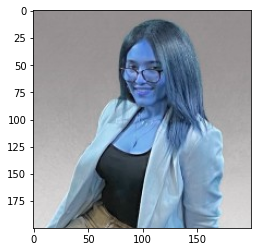

In [15]:
plt.imshow(image_array)
print(probs)
print(pred)